In [1]:
import random
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import random
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
EPISODES = 100

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
        
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            #target = 0
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)
    
    def represent_state(self,state,n):
        l = state.tolist()[0]
        l = [str(i) for i in l]
        tup_state_rep = [l[i:i+n] for i in range(0,len(l),n)]
        #print(tup_state_rep)
        for i in range(n):
            print(i+1,"--",' '.join(tup_state_rep[i]))
        print("\n")
    
    def reset_state(self,n):
        state = [0 for i in range(n*(n-1))]
        state = state+[1 for i in range(n)]
        state.append(-1)
        return np.array(state)
    
    def calc_reward(self,state, n):
                
        l = state.tolist()[:-1]
        rows = [l[i:i+n] for i in range(0,len(l),n)]
        cols = list(zip(*rows))
        
        board = [i.index(1) for i in cols]

        row_frequency = [0] * n
        main_diag_frequency = [0] * (2 * n)
        secondary_diag_frequency = [0] * (2 * n)

        for i in range(n):
            row_frequency[board[i]] += 1
            main_diag_frequency[board[i] + i] += 1
            secondary_diag_frequency[n - board[i] + i] += 1

        conflicts = 0
        # formula: (N * (N - 1)) / 2
        for i in range(2*n):
            if i < n:
                conflicts += (row_frequency[i] * (row_frequency[i]-1)) / 2
            conflicts += (main_diag_frequency[i] * (main_diag_frequency[i]-1)) / 2
            conflicts += (secondary_diag_frequency[i]
                          * (secondary_diag_frequency[i]-1)) / 2

        return int(conflicts) * -1
    
    
    def step(self,state,which_queen,action,n):
        l = state.tolist()[0][:-1]
        which_queen = which_queen-1
        for i in range(n):
            if l[n*i+which_queen]==1:
                l[n*i+which_queen]=0
                break
        
        l[n*(action-1)+which_queen] = 1
        l.append(-1)
        next_state = np.array(l)
        reward = self.calc_reward(next_state,n)
        done = False
        if reward==0:
            done = True
        
        return next_state,reward,done

        


if __name__ == "__main__":
    #Solve for 4*4
    n = 4
    #state size = n*n + 1 bit for which_queen
    state_size = n*n+1
    action_size = n
    agent = DQNAgent(state_size, action_size)
    done = False
    batch_size = 32

    #queen mapping
    queen_map = {}
    for i in range(1,n+1):
        queen_map[i] = i*10
    #queen_map = {1:10,2:20,3:30,4:40}
    
    
    converging_iters = []
    for episode in range(EPISODES):
        state = agent.reset_state(n)
        state = np.reshape(state, [1, state_size])
        print("Episode ",episode+1)
        i =0
        
        while(1):
            which_queen = i%n+1
            state = state.tolist()[0]
            
            state[-1] = queen_map[which_queen]
            state = np.array(state)
            state = np.reshape(state, [1, state_size])
            
            action = agent.act(state)
            
            next_state, reward, done = agent.step(state,which_queen,action,n)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            
            
            state = next_state
            
            if len(agent.memory) > batch_size:
                agent.replay(batch_size)
            if(reward==0):
                print("Iterations to converge on episode ",episode+1," = ",i+1)
                agent.represent_state(state,n)
                converging_iters.append(i+1)
                break
            else:
                i = i+1
                
            

Episode  1
Iterations to converge on episode  1  =  197
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  2
Iterations to converge on episode  2  =  12
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  3
Iterations to converge on episode  3  =  26
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  4
Iterations to converge on episode  4  =  38
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  5
Iterations to converge on episode  5  =  11
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  6
Iterations to converge on episode  6  =  47
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  7
Iterations to converge on episode  7  =  53
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  8
Iterations to converge on episode  8  =  7
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  9
Iterations to converge on episode  9  =  23
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  10
Iterati

Iterations to converge on episode  76  =  9
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  77
Iterations to converge on episode  77  =  11
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  78
Iterations to converge on episode  78  =  9
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  79
Iterations to converge on episode  79  =  13
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  80
Iterations to converge on episode  80  =  7
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  81
Iterations to converge on episode  81  =  7
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  82
Iterations to converge on episode  82  =  7
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  83
Iterations to converge on episode  83  =  7
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  84
Iterations to converge on episode  84  =  7
1 -- 0 1 0 0
2 -- 0 0 0 1
3 -- 1 0 0 0
4 -- 0 0 1 0


Episode  85
Iteratio

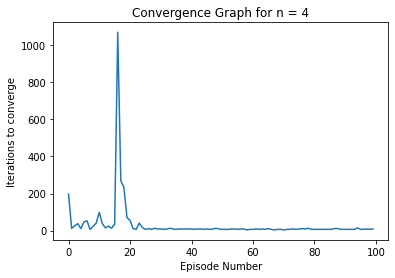

In [3]:
plt.title("Convergence Graph for n = "+str(n))
plt.plot([i for i in range(len(converging_iters))],converging_iters)
plt.xlabel("Episode Number")
plt.ylabel("Iterations to converge")
plt.show()

In [4]:
converging_iters

[197,
 12,
 26,
 38,
 11,
 47,
 53,
 7,
 23,
 41,
 99,
 37,
 15,
 25,
 13,
 35,
 1069,
 269,
 233,
 71,
 55,
 11,
 7,
 41,
 17,
 7,
 11,
 7,
 13,
 9,
 9,
 7,
 9,
 13,
 9,
 7,
 9,
 9,
 9,
 9,
 9,
 7,
 9,
 9,
 7,
 9,
 7,
 9,
 13,
 9,
 7,
 7,
 7,
 9,
 9,
 7,
 9,
 9,
 4,
 7,
 7,
 9,
 7,
 9,
 7,
 11,
 7,
 4,
 7,
 7,
 4,
 7,
 7,
 9,
 7,
 9,
 11,
 9,
 13,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 9,
 13,
 9,
 7,
 7,
 7,
 7,
 7,
 15,
 7,
 7,
 9,
 7,
 9]

In [5]:
converging_iters[21]

11

In [6]:
#plot_model(agent.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
